In [1]:
"""
This file replicates the querying process of IVF_PQ index. 
It also provides function that can retrieve 
the coarse grained cluster centroids, the sub-quantizer centroids，
and the PQ codes of each Voronoi cells.
"""

'\nThis file replicates the querying process of IVF_PQ index. \nIt also provides function that can retrieve \nthe coarse grained cluster centroids, the sub-quantizer centroids，\nand the PQ codes of each Voronoi cells.\n'

In [3]:
import numpy as np
import faiss
import sys
from matplotlib import pyplot

In [4]:
# Set parameters
nlist = 1024
m = 16
kbits = 8 # 2^5 = 32, 2^8 = 256
d = 128

# Create an IVFPQ index
coarse_quantizer = faiss.IndexFlatL2(d)
index = faiss.IndexIVFPQ(coarse_quantizer, d, nlist, m, kbits)

# Fill in training vectors
db_size = 100000
xb = faiss.rand((db_size, d), 1234)
index.train(xb)
index.add(xb)

In [5]:
"""
https://github.com/facebookresearch/faiss/blob/master/faiss/IndexIVFPQ.h

IndexIVFPQ (
        Index * quantizer, size_t d, size_t nlist,
        size_t M, size_t nbits_per_idx, MetricType metric = METRIC_L2);
"""

'\nhttps://github.com/facebookresearch/faiss/blob/master/faiss/IndexIVFPQ.h\n\nIndexIVFPQ (\n        Index * quantizer, size_t d, size_t nlist,\n        size_t M, size_t nbits_per_idx, MetricType metric = METRIC_L2);\n'

In [5]:
def get_sub_quantizer_centroids(index):
    """
    return the sub-quantizer centroids, 
    shape = (m, 256, d / m)
    e.g., d=128, m=16 -> (16, 256, 8)
    """
    pq = index.pq
    cen = faiss.vector_to_array(pq.centroids)
    cen = cen.reshape(pq.M, pq.ksub, pq.dsub)
    
    return cen

In [6]:
def get_coarse_quantizer_centroids(coarse_quantizer):
    """
    return the coarse-grained quantizer centroids,
    shape = (nlist, d),
    e.g., nlist=1024, d=128 -> (1024, 128)
    """
    coarse_cen = faiss.vector_to_array(coarse_quantizer.xb)
#     print("coarse_cen.shape", coarse_cen.shape) # 1024 * 64 = 65536
#     print("coarse_quantizer.ntotal", coarse_quantizer.ntotal)
#     print("coarse_quantizer.d", coarse_quantizer.d)

    coarse_cen = coarse_cen.reshape(coarse_quantizer.ntotal, coarse_quantizer.d)
    return coarse_cen

In [17]:
# Get Sub quantizer info
sub_cen = get_sub_quantizer_centroids(index)
print("==== Sub-quantizer ====\n{}\n\nshape:{}\n".format(sub_cen, sub_cen.shape))

# Get Coarse quantizer info
coarse_cen = get_coarse_quantizer_centroids(coarse_quantizer)
print("==== Coarse-quantizer ====\n{}\n\nshape:{}\n".format(coarse_cen, coarse_cen.shape))

==== Sub-quantizer ====
[[[ 0.17924231 -0.2749313   0.29144537 ... -0.29495844 -0.18699668
   -0.20414156]
  [-0.07844483  0.30854055  0.34186772 ... -0.12987636 -0.33454713
    0.02798734]
  [-0.24824859 -0.20259492 -0.2560874  ... -0.18432462 -0.20422956
    0.2681094 ]
  ...
  [-0.35703084 -0.19456549 -0.21670225 ... -0.20177144 -0.13965316
    0.2969404 ]
  [ 0.00852142 -0.23655796  0.35761082 ...  0.2068314   0.24348426
    0.14710034]
  [ 0.34853867  0.24494384 -0.20898949 ... -0.07019396 -0.13175721
    0.31903544]]

 [[-0.2141963   0.27197307  0.01220241 ... -0.24688241 -0.3274523
    0.230294  ]
  [ 0.25678748 -0.24011876 -0.18555477 ...  0.26959166  0.28371984
   -0.21465817]
  [ 0.17304586  0.09377105  0.2553503  ... -0.38982227 -0.07005366
   -0.26379895]
  ...
  [-0.25902578 -0.19465874 -0.31856865 ...  0.24783067  0.23450364
    0.2573352 ]
  [-0.23139088  0.28276306  0.24413203 ... -0.180948   -0.17281164
   -0.24686007]
  [ 0.25360247  0.16767755 -0.32378525 ...  0.2567

In [15]:
print(type(coarse_quantizer))
print(dir(coarse_quantizer))

<class 'faiss.swigfaiss_avx2.IndexFlatL2'>
['__class__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__swig_destroy__', '__swig_getmethods__', '__swig_setmethods__', '__weakref__', '_s', 'add', 'add_c', 'add_with_ids', 'add_with_ids_c', 'assign', 'assign_c', 'compute_distance_subset', 'compute_residual', 'compute_residual_n', 'd', 'get_distance_computer', 'is_trained', 'metric_arg', 'metric_type', 'ntotal', 'range_search', 'range_search_c', 'reconstruct', 'reconstruct_c', 'reconstruct_n', 'reconstruct_n_c', 'remove_ids', 'remove_ids_c', 'reset', 'sa_code_size', 'sa_decode', 'sa_decode_c', 'sa_encode', 'sa_encode_c', 'search', 'search_and_reconstruct', 'search_and_reconstruct_c', 'search_c', '

In [9]:
def get_invlist(invlists, l):
    """ 
    returns the (vector IDs set, PQ cose set) of list ID "l"
    list_ids: (#vec_in_list, ), e.g., #vec_in_list=10 -> (10, )
    list_codes: (#vec_in_list, m), e.g., #vec_in_list=10, m=16 -> (10, 16)
    
    That the data is *NOT* copied: if the inverted index is deallocated or changes, accessing the array may crash.
    To avoid this, just clone the output arrays on output. 
    """
    ls = invlists.list_size(l)
    list_ids = faiss.rev_swig_ptr(invlists.get_ids(l), ls)
    list_codes = faiss.rev_swig_ptr(invlists.get_codes(l), ls * invlists.code_size)
    list_codes = list_codes.reshape(-1, invlists.code_size)
    return list_ids, list_codes

In [14]:
invlists = index.invlists

# Example of using function "get_invlist"
list_id = 124
list_ids, list_codes = get_invlist(invlists, list_id)
print("==== Vector IDs ====\n{}\n\nshape: {}\n".format(list_ids, list_ids.shape))
print("==== PQ codes ====\n{}\n\nshape: {}\n".format(list_codes, list_codes.shape))

==== Vector IDs ====
[ 1854  2205  2782  4419  4924  5751  8629  9319  9757  9771  9947 11158
 13424 15397 17386 17448 18355 18403 18944 19188 21068 22108 22846 24542
 25870 26680 27304 27993 29243 30833 31495 31574 32347 32532 32859 33540
 33569 35466 36036 36943 39222 40446 41591 41964 42397 43282 45791 46308
 46459 46573 46595 47319 50184 50907 53231 53444 54099 54472 56151 56698
 57223 57462 59261 61652 62738 63406 64196 64795 68244 70205 70317 70387
 70589 71626 72616 73361 73758 74577 75744 77104 77191 77860 78009 78801
 79891 80119 81488 82338 82367 82425 83562 83719 84576 84889 85519 88669
 89512 89555 90840 92470 92989 93456 93604 94566 95142 96076 97779 97990
 98107 98432 99780]

shape: (111,)

==== PQ codes ====
[[154 114 204 ... 116 237  44]
 [173 206 105 ... 107 196 197]
 [ 37 250 175 ... 211 113 193]
 ...
 [141 164 145 ...  25 224 196]
 [177  75 124 ...   6 163  47]
 [136 135 192 ...  64 187  33]]

shape: (111, 16)



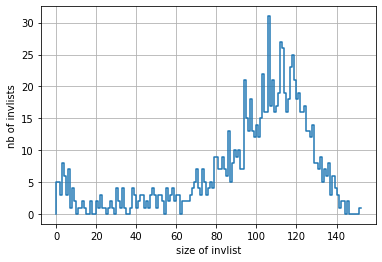

In [15]:
# Show size Distribution of all cells (inverted lists)
bc = np.bincount([invlists.list_size(l) for l in range(invlists.nlist)])
pyplot.step(np.arange(bc.size), bc)
pyplot.xlabel('size of invlist')
pyplot.ylabel('nb of invlists')
pyplot.grid()

In [81]:
# Set Paramter Space
# parametersets = sys.argv[3:] -> nprobe=1 nprobe=2 nprobe=4 
# python bench_polysemous_1bn.py SIFT1000M OPQ8,IVF262144,PQ8 nprobe=1 nprobe=2 nprobe=4 

ps = faiss.ParameterSpace()
ps.initialize(index)

# for param in parametersets:
#         print(param, '\t', end=' ')
#         sys.stdout.flush()
#         ps.set_index_parameters(index, param)

def set_nprobe(index, nprobe):
    param = 'nprobe={}'.format(nprobe)
    ps.set_index_parameters(index, param)
    
nprobe = 16
set_nprobe(index, nprobe)

In [122]:
# Generate query vector and perform search

batch_size = 4
q_vecs = faiss.rand((batch_size, d), 123)

topk = 10
distance, vector = index.search(q_vecs, k=topk)

print("======= Query Vector ========\n\n{}\n".format(q))
print("======= Vector ID ========\n\n{}\n".format(vector))
print("======= Distance ========\n\n{}\n".format(distance))

======= Query Vector ========

[[0.75718063 0.3194483  0.00431789 ... 0.38341647 0.88752866 0.04687348]
 [0.8086562  0.35178575 0.2990955  ... 0.18595378 0.8855425  0.23872687]
 [0.37312934 0.09708098 0.00955685 ... 0.28287494 0.7812909  0.9145271 ]
 ...
 [0.4019066  0.23548792 0.2437029  ... 0.9850208  0.59467167 0.9535872 ]
 [0.55136377 0.71406645 0.83495665 ... 0.6054929  0.2561835  0.37356353]
 [0.25708562 0.67164904 0.5520859  ... 0.2899048  0.43975452 0.5190886 ]]

======= Vector ID ========

[[  884 95320 27561 53369 63624  1907 42982 50223 17714 61144]
 [62513 90384 25844 54475 71406 81490 81139  3828 24723 11213]
 [99308 26566 81538 19836 80841 95568 22448 13195 30934 12019]
 [12413 90306 95220 77171 52601  6166 78366 18901 71815 55414]]

======= Distance ========

[[11.610527 12.416188 12.445366 12.559515 12.660251 12.713934 12.836206
  12.840525 12.870458 12.891409]
 [12.090574 12.944919 13.334971 13.408017 13.494866 13.507541 13.621208
  13.837109 13.842428 13.847662]
 [13.

In [126]:
"""
Self-implemented functions to search a query vectors
"""

def distance_full_vec(v1, v2):
    """Given 2 full vector, return their L2 distance"""
    assert len(v1) == len(v2)
    v_diff = v1 - v2
    dist = np.sum(v_diff * v_diff)
    return dist

def construct_distance_table(q_res, sub_cen):
    """
    q_res: a full precision query vector, shape = (d, ), e.g., (128, )
    sub_cen: sub-quantizer center, shape = (m, 256, d / m), e.g., d=128, m=16 -> (16, 256, 8)
    """
    M, ksub, dsub = sub_cen.shape
    dist_table = np.zeros(shape=(M, ksub))
    
    for m in range(M):
        q_res_part = q_res[m * dsub: (m + 1) * dsub]
        for k in range(ksub):
            PQ_cent = sub_cen[m][k]
            res_dist = PQ_cent - q_res_part
            dist = np.sum(res_dist * res_dist)
            
            dist_table[m, k] = dist
            
    return dist_table

def estimate_distance(pq_code, dist_table):
    """
    given single PQ code and its distance table, compute the estimated distance
    """
    # pq_cen -> (pq.M 8, pq.ksub 256, pq.dsub D/M=64/8=8)
    M = dist_table.shape[0]
    assert M == len(pq_code)
    
    dist = 0
    for m in range(M):
        dist += dist_table[m][pq_code[m]]
        
    return dist

def estimate_distances(vec_ids, pq_codes, dist_table):
    """
    A wrapper of "estimate_distance", estimating the distance of a batch
      of PQ codes
    vec_ids, pq_codes: get_invlist(invlists, closest_cell)
    center_dist: the distance from query vector to the coarse-grained
      cluster centroid.
      
    Return: an sorted list of pair (vec_id, distance)
       [(vec0, dist0), ... (vecN, distN)]
    """
    assert len(vec_ids) == len(pq_codes)
    vec_dist_list = []
    
    for i in range(len(vec_ids)):
        pq_code = pq_codes[i]
        vec_id = vec_ids[i]
        dist = estimate_distance(pq_code, dist_table)# + center_dist
        vec_dist_list.append((vec_id, dist))
        
    vec_dist_list.sort(key=lambda x:x[1])
    
    return vec_dist_list

def search_single_query(q_vec, nprobe, topk, coarse_cen, sub_cen):
    """
    Search a single query vector, shape = (d, )
    """
    
    # Compute the closest centroids
    coarse_dist_ls = []
    for i, c in enumerate(coarse_cen):
        dist = distance_full_vec(q_vec, c)
        coarse_dist_ls.append((dist, i)) # (distance, cell_id)
        
    coarse_dist_ls.sort(key=lambda x: x[0])

    # Estimate distance by ADC
    closest_cell_list = coarse_dist_ls[:nprobe]
    vec_dist_id_list = []
    for cell in closest_cell_list:
        cell_id = cell[1]
        center_dist = cell[0]
        list_ids, list_codes = get_invlist(invlists, cell_id)
        q_res = q_vec - coarse_cen[cell_id]
        # Note! store sub-quantizer once, but the number of compute = nprobe 
        dist_table = construct_distance_table(q_res, sub_cen)
        vec_dist_id_list_single_cell = estimate_distances(list_ids, list_codes, dist_table)
        vec_dist_id_list += vec_dist_id_list_single_cell
        
    vec_dist_id_list.sort(key=lambda x:x[1])
    vec_dist_id_list = vec_dist_id_list[:topk]
    id_list = [pair[0] for pair in vec_dist_id_list]
    dist_list = [pair[1] for pair in vec_dist_id_list]
    
    return id_list, dist_list

def search_batch_query(q_vecs, nprobe, coarse_cen, sub_cen):
    """
    The wrapper of "search_single_query", search a batch of vectors
    """
    id_list_batch = []
    dist_list_batch = []
    for q_vec in q_vecs:
        id_list, dist_list = search_single_query(q_vec, nprobe, topk, coarse_cen, sub_cen)
        id_list_batch.append(id_list)
        dist_list_batch.append(dist_list)
        
    return id_list_batch, dist_list_batch

In [127]:
# Single query search
q_vec = q_vecs[0]

id_list, dist_list = search_single_query(q_vec, nprobe, topk, coarse_cen, sub_cen)
print("==== Vector IDs ====\n\n{}\n".format(id_list))
print("==== Distances ====\n\n{}\n".format(dist_list))

==== Vector IDs ====

[884, 95320, 27561, 53369, 63624, 1907, 42982, 50223, 17714, 61144]

==== Distances ====

[11.610528707504272, 12.416190445423126, 12.445367276668549, 12.559513688087463, 12.660250276327133, 12.713933110237122, 12.836208432912827, 12.840526193380356, 12.870455980300903, 12.891409903764725]



In [128]:
# Batch query search

id_list_batch, dist_list_batch = search_batch_query(q_vecs, nprobe, coarse_cen, sub_cen)
print("==== Vector IDs ====\n\n{}\n".format(np.array(id_list_batch)), sep="]")
print("==== Distances ====\n\n{}\n".format(np.array(dist_list_batch)))

==== Vector IDs ====

[[  884 95320 27561 53369 63624  1907 42982 50223 17714 61144]
 [62513 90384 25844 54475 71406 81490 81139  3828 24723 11213]
 [99308 26566 81538 19836 80841 95568 22448 13195 30934 12019]
 [12413 90306 95220 77171 52601  6166 78366 18901 71815 55414]]

==== Distances ====

[[11.61052871 12.41619045 12.44536728 12.55951369 12.66025028 12.71393311
  12.83620843 12.84052619 12.87045598 12.8914099 ]
 [12.09057298 12.94492209 13.33497161 13.40802002 13.49486633 13.50754137
  13.62120849 13.83710781 13.84242672 13.84766155]
 [13.7015377  13.82044643 13.83121002 13.92408744 14.01268654 14.05528095
  14.13906267 14.16826037 14.17790705 14.26089627]
 [11.02061656 12.10482168 12.33258024 12.50031289 12.54708323 12.56589916
  12.59289175 12.78142619 13.00950569 13.03845951]]



In [129]:
print(np.allclose(id_list_batch, vector))
print(np.allclose(dist_list_batch, distance))

# Faiss Result

# ======= Vector ID ========

# [[  884 95320 27561 53369 63624  1907 42982 50223 17714 61144]
#  [62513 90384 25844 54475 71406 81490 81139  3828 24723 11213]
#  [99308 26566 81538 19836 80841 95568 22448 13195 30934 12019]
#  [12413 90306 95220 77171 52601  6166 78366 18901 71815 55414]]

# ======= Distance ========

# [[11.610527 12.416188 12.445366 12.559515 12.660251 12.713934 12.836206
#   12.840525 12.870458 12.891409]
#  [12.090574 12.944919 13.334971 13.408017 13.494866 13.507541 13.621208
#   13.837109 13.842428 13.847662]
#  [13.701537 13.820447 13.83121  13.924089 14.012687 14.055279 14.139063
#   14.168261 14.177904 14.260893]
#  [11.020613 12.104823 12.332581 12.500315 12.547085 12.565901 12.592893
#   12.781424 13.009505 13.038458]]

True
True


In [132]:
"""
Why NOT adding distance(cell center, query vector) to the estimated distance by LUT?
Answer: When constructing distance table, we already use (q - center) as input. 
Thus, the resulting lookup table already includes information of cell centroids
"""

'\nWhy NOT adding distance(cell center, query vector) to the estimated distance by LUT?\nAnswer: When constructing distance table, we already use (q - center) as input. \nThus, the resulting lookup table already includes information of cell centroids\n'